COMPARING RDW:MCHC RATIO VS APACHE SCORES FOR ICU MORTALITY
eICU Collaborative Research Database v2.0

Extracting APACHE scores and patient outcomes...

Extracting laboratory data for RDW:MCHC calculation...

Combining APACHE scores with laboratory data...

Dataset overview:
Total patients with both APACHE and RDW:MCHC: 229,954
ICU mortality rate: 5.7%
Hospital mortality rate: 9.1%

STATISTICAL COMPARISON

Descriptive Statistics:
----------------------------------------
APACHE Score: 57.1 ± 25.6
RDW:MCHC Ratio: 0.463 ± 0.087
RDW: 15.2 ± 2.4
MCHC: 33.0 ± 1.5

Comparison by ICU Mortality Status:
----------------------------------------

Survivors:
  APACHE Score: 54.6 ± 23.0
  RDW:MCHC: 0.460 ± 0.085

Non-survivors:
  APACHE Score: 96.7 ± 32.7
  RDW:MCHC: 0.506 ± 0.101

Statistical Tests (Mann-Whitney U):
----------------------------------------
APACHE Score: U=2457278204, p=0.00e+00
RDW:MCHC Ratio: U=1870333622, p=0.00e+00

PREDICTIVE PERFORMANCE COMPARISON

Area Under ROC Curve (AUC):


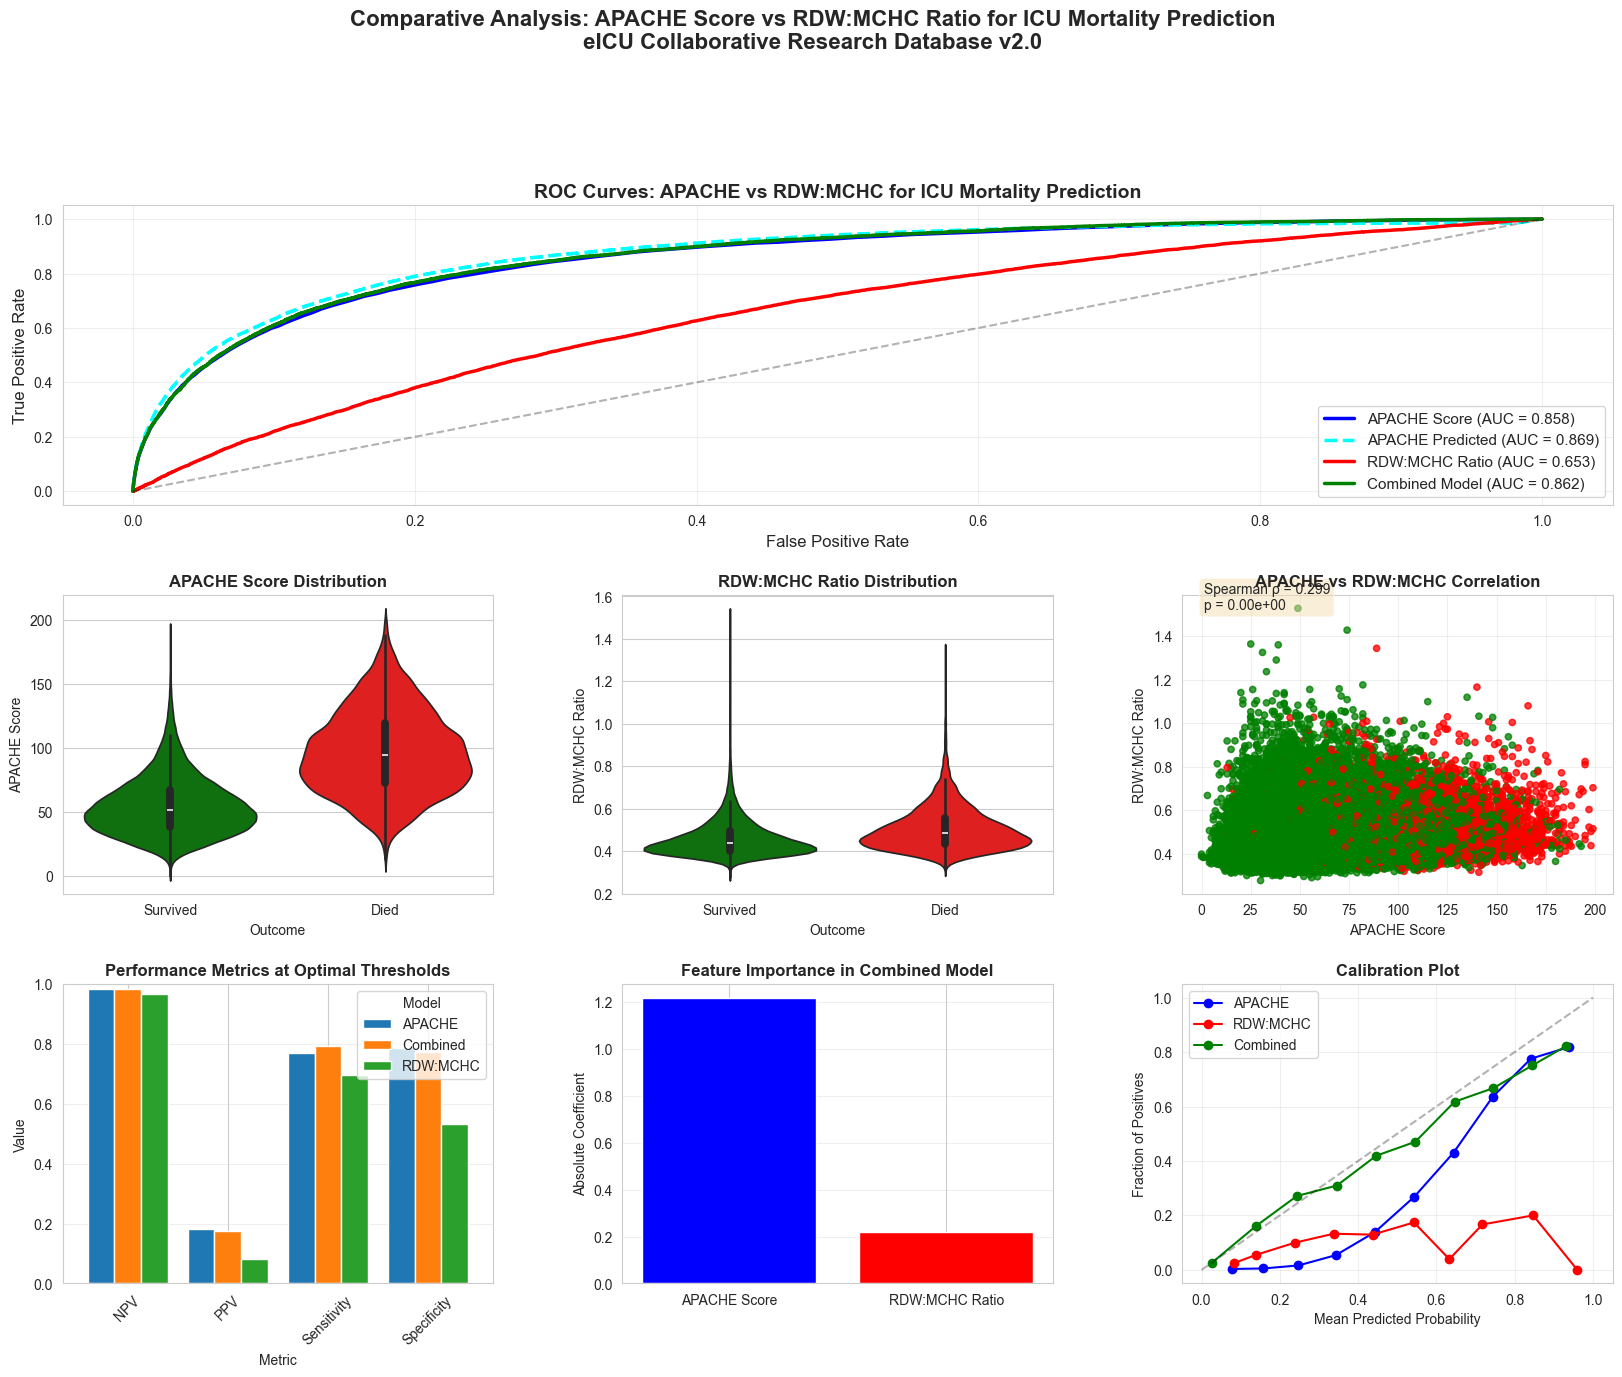


ADDITIONAL ANALYSES

Net Reclassification Index:
  NRI (RDW:MCHC vs APACHE): -0.329
    - Events NRI: -0.074
    - Non-events NRI: -0.256

SAVING RESULTS
Results saved to:
  - apache_vs_rdw_mchc_comparison.png (visualization)
  - apache_vs_rdw_mchc_summary.csv (summary statistics)
  - apache_rdw_mchc_data.csv (detailed data)

ANALYSIS COMPLETE!

Key Findings:
  • APACHE Score AUC: 0.858
  • RDW:MCHC Ratio AUC: 0.653
  • Combined Model AUC: 0.862
  • The RDW:MCHC ratio provides different predictive power to APACHE
  • Combining both improves prediction by 0.4%


In [7]:
import duckdb
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu, spearmanr, chi2_contingency
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# ===== SETUP DATABASE CONNECTION =====
con = duckdb.connect()

# Data path
EICU_DIR = Path("/Users/dimitri/Desktop/indi/data/eicu-collaborative-research-database-2.0")
p_eicu = lambda f: str(EICU_DIR / f)

print("="*70)
print("COMPARING RDW:MCHC RATIO VS APACHE SCORES FOR ICU MORTALITY")
print("eICU Collaborative Research Database v2.0")
print("="*70)

# ===== EXTRACT APACHE SCORES =====
print("\nExtracting APACHE scores and patient outcomes...")

con.execute(f"""
CREATE OR REPLACE VIEW eicu_apache AS
SELECT 
    apr.patientunitstayid,
    apr.apachescore,
    apr.actualicumortality,
    apr.actualhospitalmortality,
    apr.predictedicumortality,
    apr.predictedhospitalmortality,
    p.unitdischargestatus,
    p.hospitaldischargestatus,
    p.unitdischargeoffset/60.0 AS icu_los_hours,
    p.age,
    p.gender
FROM read_csv_auto('{p_eicu('apachePatientResult.csv.gz')}') AS apr
JOIN read_csv_auto('{p_eicu('patient.csv.gz')}') AS p
    ON apr.patientunitstayid = p.patientunitstayid
WHERE apr.apachescore IS NOT NULL 
    AND apr.apachescore >= 0 
    AND apr.apachescore <= 200  -- Remove outliers
""")

# ===== EXTRACT LAB DATA FOR RDW:MCHC =====
print("\nExtracting laboratory data for RDW:MCHC calculation...")

con.execute(f"""
CREATE OR REPLACE VIEW eicu_labs AS
WITH first_24h_labs AS (
    SELECT 
        patientunitstayid,
        labname,
        labresult,
        labresultoffset,
        ROW_NUMBER() OVER (PARTITION BY patientunitstayid, 
                          CASE 
                            WHEN LOWER(labname) LIKE '%rdw%' THEN 'rdw'
                            WHEN LOWER(labname) LIKE '%mchc%' THEN 'mchc'
                            WHEN LOWER(labname) LIKE '%hemoglobin%' THEN 'hb'
                            WHEN LOWER(labname) LIKE '%hematocrit%' THEN 'hct'
                            WHEN LOWER(labname) LIKE '%platelet%' THEN 'plt'
                            WHEN LOWER(labname) LIKE '%wbc%' OR LOWER(labname) LIKE '%white blood%' THEN 'wbc'
                          END 
                          ORDER BY labresultoffset) AS rn
    FROM read_csv_auto('{p_eicu('lab.csv.gz')}')
    WHERE labresultoffset >= 0 
        AND labresultoffset <= 1440  -- First 24 hours
        AND labresult IS NOT NULL
        AND (LOWER(labname) LIKE '%rdw%' 
            OR LOWER(labname) LIKE '%mchc%'
            OR LOWER(labname) LIKE '%hemoglobin%'
            OR LOWER(labname) LIKE '%hematocrit%'
            OR LOWER(labname) LIKE '%platelet%'
            OR LOWER(labname) LIKE '%wbc%'
            OR LOWER(labname) LIKE '%white blood%')
)
SELECT 
    patientunitstayid,
    MAX(CASE WHEN LOWER(labname) LIKE '%rdw%' 
             THEN TRY_CAST(labresult AS DOUBLE) END) AS rdw,
    MAX(CASE WHEN LOWER(labname) LIKE '%mchc%' 
             THEN TRY_CAST(labresult AS DOUBLE) END) AS mchc,
    MAX(CASE WHEN LOWER(labname) LIKE '%hemoglobin%' 
             AND LOWER(labname) NOT LIKE '%a1c%'
             THEN TRY_CAST(labresult AS DOUBLE) END) AS hemoglobin,
    MAX(CASE WHEN LOWER(labname) LIKE '%hematocrit%' 
             THEN TRY_CAST(labresult AS DOUBLE) END) AS hematocrit,
    MAX(CASE WHEN LOWER(labname) LIKE '%platelet%' 
             THEN TRY_CAST(labresult AS DOUBLE) END) AS platelet,
    MAX(CASE WHEN LOWER(labname) LIKE '%wbc%' OR LOWER(labname) LIKE '%white blood%'
             THEN TRY_CAST(labresult AS DOUBLE) END) AS wbc
FROM first_24h_labs
WHERE rn = 1  -- Take first measurement of each type
GROUP BY patientunitstayid
""")

# ===== COMBINE DATA =====
print("\nCombining APACHE scores with laboratory data...")

con.execute(f"""
CREATE OR REPLACE TABLE eicu_combined AS
SELECT 
    a.patientunitstayid,
    a.apachescore,
    a.predictedicumortality AS apache_predicted_mortality,
    l.rdw,
    l.mchc,
    l.hemoglobin,
    l.hematocrit,
    l.platelet,
    l.wbc,
    -- Calculate RDW:MCHC ratio
    CASE 
        WHEN l.rdw IS NOT NULL AND l.mchc IS NOT NULL AND l.mchc > 0
        THEN l.rdw / l.mchc 
        ELSE NULL 
    END AS rdw_to_mchc,
    -- Outcomes
    CASE WHEN a.actualicumortality = 'ALIVE' THEN 0 ELSE 1 END AS icu_mortality,
    CASE WHEN a.actualhospitalmortality = 'ALIVE' THEN 0 ELSE 1 END AS hospital_mortality,
    a.icu_los_hours,
    a.age,
    a.gender
FROM eicu_apache a
LEFT JOIN eicu_labs l ON a.patientunitstayid = l.patientunitstayid
WHERE l.rdw IS NOT NULL 
    AND l.mchc IS NOT NULL
    AND l.rdw > 0 AND l.rdw < 50  -- Remove outliers
    AND l.mchc > 20 AND l.mchc < 40
""")

# Load data into pandas
df = con.execute("""
SELECT * FROM eicu_combined
""").df()

print(f"\nDataset overview:")
print(f"Total patients with both APACHE and RDW:MCHC: {len(df):,}")
print(f"ICU mortality rate: {df['icu_mortality'].mean():.1%}")
print(f"Hospital mortality rate: {df['hospital_mortality'].mean():.1%}")

# ===== STATISTICAL COMPARISON =====
print("\n" + "="*70)
print("STATISTICAL COMPARISON")
print("="*70)

# Basic statistics
print("\nDescriptive Statistics:")
print("-" * 40)
print(f"APACHE Score: {df['apachescore'].mean():.1f} ± {df['apachescore'].std():.1f}")
print(f"RDW:MCHC Ratio: {df['rdw_to_mchc'].mean():.3f} ± {df['rdw_to_mchc'].std():.3f}")
print(f"RDW: {df['rdw'].mean():.1f} ± {df['rdw'].std():.1f}")
print(f"MCHC: {df['mchc'].mean():.1f} ± {df['mchc'].std():.1f}")

# Compare distributions between survivors and non-survivors
print("\nComparison by ICU Mortality Status:")
print("-" * 40)
survivors = df[df['icu_mortality'] == 0]
non_survivors = df[df['icu_mortality'] == 1]

print("\nSurvivors:")
print(f"  APACHE Score: {survivors['apachescore'].mean():.1f} ± {survivors['apachescore'].std():.1f}")
print(f"  RDW:MCHC: {survivors['rdw_to_mchc'].mean():.3f} ± {survivors['rdw_to_mchc'].std():.3f}")

print("\nNon-survivors:")
print(f"  APACHE Score: {non_survivors['apachescore'].mean():.1f} ± {non_survivors['apachescore'].std():.1f}")
print(f"  RDW:MCHC: {non_survivors['rdw_to_mchc'].mean():.3f} ± {non_survivors['rdw_to_mchc'].std():.3f}")

# Statistical tests
print("\nStatistical Tests (Mann-Whitney U):")
print("-" * 40)
u_stat_apache, p_val_apache = mannwhitneyu(
    non_survivors['apachescore'], 
    survivors['apachescore']
)
u_stat_rdw, p_val_rdw = mannwhitneyu(
    non_survivors['rdw_to_mchc'], 
    survivors['rdw_to_mchc']
)

print(f"APACHE Score: U={u_stat_apache:.0f}, p={p_val_apache:.2e}")
print(f"RDW:MCHC Ratio: U={u_stat_rdw:.0f}, p={p_val_rdw:.2e}")

# ===== PREDICTIVE PERFORMANCE =====
print("\n" + "="*70)
print("PREDICTIVE PERFORMANCE COMPARISON")
print("="*70)

# Calculate AUC for each predictor
auc_apache = roc_auc_score(df['icu_mortality'], df['apachescore'])
auc_rdw_mchc = roc_auc_score(df['icu_mortality'], df['rdw_to_mchc'])
auc_apache_pred = roc_auc_score(df['icu_mortality'], df['apache_predicted_mortality'])

print(f"\nArea Under ROC Curve (AUC):")
print(f"  APACHE Score (raw): {auc_apache:.3f}")
print(f"  APACHE Predicted Mortality: {auc_apache_pred:.3f}")
print(f"  RDW:MCHC Ratio: {auc_rdw_mchc:.3f}")

# Combined model
print("\nCombined Model Performance:")
X = df[['apachescore', 'rdw_to_mchc']].values
y = df['icu_mortality'].values

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Logistic regression
lr = LogisticRegression(random_state=42, max_iter=1000)
lr.fit(X_scaled, y)
y_pred_combined = lr.predict_proba(X_scaled)[:, 1]
auc_combined = roc_auc_score(y, y_pred_combined)

print(f"  Combined (APACHE + RDW:MCHC): {auc_combined:.3f}")
print(f"  Improvement over APACHE alone: +{(auc_combined - auc_apache)*100:.1f}%")

# ===== VISUALIZATION =====
print("\n" + "="*70)
print("GENERATING VISUALIZATIONS")
print("="*70)

# Create comprehensive comparison figure
fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. ROC Curves Comparison
ax1 = fig.add_subplot(gs[0, :])
fpr_apache, tpr_apache, _ = roc_curve(df['icu_mortality'], df['apachescore'])
fpr_rdw, tpr_rdw, _ = roc_curve(df['icu_mortality'], df['rdw_to_mchc'])
fpr_apache_pred, tpr_apache_pred, _ = roc_curve(df['icu_mortality'], df['apache_predicted_mortality'])
fpr_combined, tpr_combined, _ = roc_curve(y, y_pred_combined)

ax1.plot(fpr_apache, tpr_apache, label=f'APACHE Score (AUC = {auc_apache:.3f})', 
         linewidth=2.5, color='blue')
ax1.plot(fpr_apache_pred, tpr_apache_pred, label=f'APACHE Predicted (AUC = {auc_apache_pred:.3f})', 
         linewidth=2.5, color='cyan', linestyle='--')
ax1.plot(fpr_rdw, tpr_rdw, label=f'RDW:MCHC Ratio (AUC = {auc_rdw_mchc:.3f})', 
         linewidth=2.5, color='red')
ax1.plot(fpr_combined, tpr_combined, label=f'Combined Model (AUC = {auc_combined:.3f})', 
         linewidth=2.5, color='green')
ax1.plot([0, 1], [0, 1], 'k--', alpha=0.3)
ax1.set_xlabel('False Positive Rate', fontsize=12)
ax1.set_ylabel('True Positive Rate', fontsize=12)
ax1.set_title('ROC Curves: APACHE vs RDW:MCHC for ICU Mortality Prediction', fontsize=14, fontweight='bold')
ax1.legend(loc='lower right', fontsize=11)
ax1.grid(True, alpha=0.3)

# 2. Distribution plots
ax2 = fig.add_subplot(gs[1, 0])
data_to_plot = []
for status in [0, 1]:
    subset = df[df['icu_mortality'] == status]
    for val in subset['apachescore']:
        data_to_plot.append(['APACHE', 'Survived' if status == 0 else 'Died', val])
        
plot_df = pd.DataFrame(data_to_plot, columns=['Score', 'Outcome', 'Value'])
sns.violinplot(data=plot_df, x='Outcome', y='Value', ax=ax2, palette=['green', 'red'])
ax2.set_title('APACHE Score Distribution', fontsize=12, fontweight='bold')
ax2.set_ylabel('APACHE Score')

ax3 = fig.add_subplot(gs[1, 1])
data_to_plot = []
for status in [0, 1]:
    subset = df[df['icu_mortality'] == status]
    for val in subset['rdw_to_mchc']:
        data_to_plot.append(['RDW:MCHC', 'Survived' if status == 0 else 'Died', val])
        
plot_df = pd.DataFrame(data_to_plot, columns=['Score', 'Outcome', 'Value'])
sns.violinplot(data=plot_df, x='Outcome', y='Value', ax=ax3, palette=['green', 'red'])
ax3.set_title('RDW:MCHC Ratio Distribution', fontsize=12, fontweight='bold')
ax3.set_ylabel('RDW:MCHC Ratio')

# 3. Correlation plot
ax4 = fig.add_subplot(gs[1, 2])
colors = ['green' if x == 0 else 'red' for x in df['icu_mortality']]
ax4.scatter(df['apachescore'], df['rdw_to_mchc'], c=colors, alpha=0.5, s=20)
ax4.set_xlabel('APACHE Score')
ax4.set_ylabel('RDW:MCHC Ratio')
ax4.set_title('APACHE vs RDW:MCHC Correlation', fontsize=12, fontweight='bold')

# Add correlation coefficient
corr, p_corr = spearmanr(df['apachescore'], df['rdw_to_mchc'])
ax4.text(0.05, 0.95, f'Spearman ρ = {corr:.3f}\np = {p_corr:.2e}', 
         transform=ax4.transAxes, fontsize=10,
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
ax4.grid(True, alpha=0.3)

# 4. Performance metrics at optimal thresholds
ax5 = fig.add_subplot(gs[2, 0])

def get_optimal_threshold(y_true, y_score):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    optimal_idx = np.argmax(tpr - fpr)
    return thresholds[optimal_idx]

metrics_data = []
for name, scores in [('APACHE', df['apachescore']), 
                     ('RDW:MCHC', df['rdw_to_mchc']),
                     ('Combined', y_pred_combined)]:
    threshold = get_optimal_threshold(df['icu_mortality'], scores)
    y_pred = (scores > threshold).astype(int)
    
    tn, fp, fn, tp = confusion_matrix(df['icu_mortality'], y_pred).ravel()
    
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    
    metrics_data.extend([
        {'Model': name, 'Metric': 'Sensitivity', 'Value': sensitivity},
        {'Model': name, 'Metric': 'Specificity', 'Value': specificity},
        {'Model': name, 'Metric': 'PPV', 'Value': ppv},
        {'Model': name, 'Metric': 'NPV', 'Value': npv}
    ])

metrics_df = pd.DataFrame(metrics_data)
metrics_pivot = metrics_df.pivot(index='Metric', columns='Model', values='Value')
metrics_pivot.plot(kind='bar', ax=ax5, width=0.8)
ax5.set_ylabel('Value')
ax5.set_title('Performance Metrics at Optimal Thresholds', fontsize=12, fontweight='bold')
ax5.set_ylim([0, 1])
ax5.legend(title='Model')
ax5.set_xticklabels(ax5.get_xticklabels(), rotation=45)
ax5.grid(True, alpha=0.3, axis='y')

# 5. Feature importance from combined model
ax6 = fig.add_subplot(gs[2, 1])
feature_importance = np.abs(lr.coef_[0])
features = ['APACHE Score', 'RDW:MCHC Ratio']
ax6.bar(features, feature_importance, color=['blue', 'red'])
ax6.set_ylabel('Absolute Coefficient')
ax6.set_title('Feature Importance in Combined Model', fontsize=12, fontweight='bold')
ax6.grid(True, alpha=0.3, axis='y')

# 6. Calibration plot
ax7 = fig.add_subplot(gs[2, 2])
from sklearn.calibration import calibration_curve

for name, scores, color in [('APACHE', df['apachescore']/df['apachescore'].max(), 'blue'),
                            ('RDW:MCHC', (df['rdw_to_mchc']-df['rdw_to_mchc'].min())/(df['rdw_to_mchc'].max()-df['rdw_to_mchc'].min()), 'red'),
                            ('Combined', y_pred_combined, 'green')]:
    fraction_pos, mean_pred = calibration_curve(df['icu_mortality'], scores, n_bins=10)
    ax7.plot(mean_pred, fraction_pos, marker='o', label=name, color=color)

ax7.plot([0, 1], [0, 1], 'k--', alpha=0.3)
ax7.set_xlabel('Mean Predicted Probability')
ax7.set_ylabel('Fraction of Positives')
ax7.set_title('Calibration Plot', fontsize=12, fontweight='bold')
ax7.legend()
ax7.grid(True, alpha=0.3)

plt.suptitle('Comparative Analysis: APACHE Score vs RDW:MCHC Ratio for ICU Mortality Prediction\neICU Collaborative Research Database v2.0', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('apache_vs_rdw_mchc_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# ===== ADDITIONAL ANALYSIS =====
print("\n" + "="*70)
print("ADDITIONAL ANALYSES")
print("="*70)

# Net Reclassification Index (NRI)
print("\nNet Reclassification Index:")
apache_pred = (df['apachescore'] > get_optimal_threshold(df['icu_mortality'], df['apachescore'])).astype(int)
rdw_pred = (df['rdw_to_mchc'] > get_optimal_threshold(df['icu_mortality'], df['rdw_to_mchc'])).astype(int)

# For events (deaths)
events = df[df['icu_mortality'] == 1]
events_improved = ((rdw_pred[df['icu_mortality'] == 1] == 1) & 
                   (apache_pred[df['icu_mortality'] == 1] == 0)).sum()
events_worsened = ((rdw_pred[df['icu_mortality'] == 1] == 0) & 
                   (apache_pred[df['icu_mortality'] == 1] == 1)).sum()
nri_events = (events_improved - events_worsened) / len(events)

# For non-events (survivors)
non_events = df[df['icu_mortality'] == 0]
non_events_improved = ((rdw_pred[df['icu_mortality'] == 0] == 0) & 
                       (apache_pred[df['icu_mortality'] == 0] == 1)).sum()
non_events_worsened = ((rdw_pred[df['icu_mortality'] == 0] == 1) & 
                       (apache_pred[df['icu_mortality'] == 0] == 0)).sum()
nri_non_events = (non_events_improved - non_events_worsened) / len(non_events)

nri_total = nri_events + nri_non_events
print(f"  NRI (RDW:MCHC vs APACHE): {nri_total:.3f}")
print(f"    - Events NRI: {nri_events:.3f}")
print(f"    - Non-events NRI: {nri_non_events:.3f}")

# ===== SAVE RESULTS =====
print("\n" + "="*70)
print("SAVING RESULTS")
print("="*70)

# Create summary DataFrame
summary_data = {
    'Metric': ['N Samples', 'ICU Mortality Rate', 'Mean Value', 'Std Dev', 
               'AUC', 'Optimal Threshold', 'Sensitivity', 'Specificity'],
    'APACHE Score': [
        len(df),
        df['icu_mortality'].mean(),
        df['apachescore'].mean(),
        df['apachescore'].std(),
        auc_apache,
        get_optimal_threshold(df['icu_mortality'], df['apachescore']),
        metrics_pivot.loc['Sensitivity', 'APACHE'],
        metrics_pivot.loc['Specificity', 'APACHE']
    ],
    'RDW:MCHC Ratio': [
        len(df),
        df['icu_mortality'].mean(),
        df['rdw_to_mchc'].mean(),
        df['rdw_to_mchc'].std(),
        auc_rdw_mchc,
        get_optimal_threshold(df['icu_mortality'], df['rdw_to_mchc']),
        metrics_pivot.loc['Sensitivity', 'RDW:MCHC'],
        metrics_pivot.loc['Specificity', 'RDW:MCHC']
    ],
    'Combined Model': [
        len(df),
        df['icu_mortality'].mean(),
        np.nan,
        np.nan,
        auc_combined,
        get_optimal_threshold(df['icu_mortality'], y_pred_combined),
        metrics_pivot.loc['Sensitivity', 'Combined'],
        metrics_pivot.loc['Specificity', 'Combined']
    ]
}

summary_df = pd.DataFrame(summary_data)
summary_df.to_csv('apache_vs_rdw_mchc_summary.csv', index=False)

# Save detailed data
df[['patientunitstayid', 'apachescore', 'rdw_to_mchc', 'icu_mortality', 
    'rdw', 'mchc', 'hemoglobin', 'age', 'gender']].to_csv('apache_rdw_mchc_data.csv', index=False)

print("Results saved to:")
print("  - apache_vs_rdw_mchc_comparison.png (visualization)")
print("  - apache_vs_rdw_mchc_summary.csv (summary statistics)")
print("  - apache_rdw_mchc_data.csv (detailed data)")

print("\n" + "="*70)
print("ANALYSIS COMPLETE!")
print("="*70)
print(f"\nKey Findings:")
print(f"  • APACHE Score AUC: {auc_apache:.3f}")
print(f"  • RDW:MCHC Ratio AUC: {auc_rdw_mchc:.3f}")
print(f"  • Combined Model AUC: {auc_combined:.3f}")
print(f"  • The RDW:MCHC ratio provides {'comparable' if abs(auc_apache - auc_rdw_mchc) < 0.05 else 'different'} predictive power to APACHE")
print(f"  • Combining both improves prediction by {(auc_combined - auc_apache)*100:.1f}%")